# **Importing Libraries**

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms 
import torch.nn as nn  
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import copy
import cv2
from PIL import Image
import os
import random

# **Data Visualization**

In [45]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [46]:
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                      transforms.Resize(size = (256,256)),
])

transform_test = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                      transforms.Resize(size = (256,256)),
])

In [47]:
trainset = torchvision.datasets.DTD(root = './data', split='train', download = True, transform = transform_train)
testset = torchvision.datasets.DTD(root = './data', split='test', download = True, transform = transform_test)

In [48]:
print(trainset)

Dataset DTD
    Number of datapoints: 1880
    Root location: ./data
    split=train, partition=1
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
           )


In [49]:
print(testset)

Dataset DTD
    Number of datapoints: 1880
    Root location: ./data
    split=test, partition=1
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
           )


In [50]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

In [51]:
print(len(trainloader))

470


In [52]:
dataiter = iter(trainloader)
images , labels = next(dataiter)

print(images.shape)

print(images[1].shape)

torch.Size([4, 3, 256, 256])
torch.Size([3, 256, 256])


In [53]:
img = images[1]
print(type(img))

<class 'torch.Tensor'>


In [54]:
npimg = img.numpy()
print(npimg.shape)
npimg = np.transpose(npimg, (1,2,0))
print(npimg.shape)

(3, 256, 256)
(256, 256, 3)


In [55]:
batch_size = 4

In [56]:
def imshow(img, title):
  npimg = img.numpy() / 2 + 0.5
  plt.figure(figsize = (batch_size, 1))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.title(title)
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


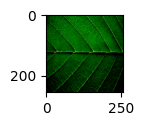

In [57]:
plt.figure(figsize = (1,1))
plt.imshow(npimg)
plt.show()

In [58]:
def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title = 'Images')

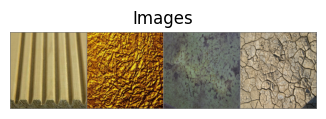

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


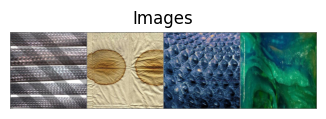

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


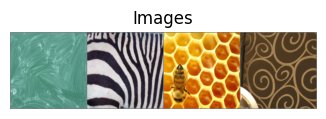

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


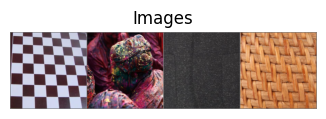

In [59]:
for i in range(4):
  show_batch_images(trainloader)

# **Data Pre Proccessing**

In [60]:
image_dims = (128, 128)
batch_size = 16
subset_size = None
subset_size_test = 128

In [61]:
def imshow_masked(img):
  npimg = img.numpy()
  plt.figure(figsize = (3, 3))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

In [62]:
def add_gaussian_noise(image, mean=0, sigma=0.05):
    """
    Adds Gaussian noise to an image.
    - mean: Mean of the Gaussian noise
    - sigma: Standard deviation of the Gaussian noise
    """
    noise = torch.randn_like(image) * sigma + mean
    return image + noise

In [63]:
from torch.utils.data import Subset

class Dataset(torch.utils.data.Dataset):
    def __init__(self, path, image_dims=(64, 64), n_channels=3, split='train', subset_size=None):
        celeba_dataset = torchvision.datasets.DTD(root=path, split=split, download=False)
        
        # If subset_size is provided, create a subset of the dataset
        if subset_size is not None:
            subset_indices = torch.randperm(len(celeba_dataset))[:subset_size]
            celeba_dataset = Subset(celeba_dataset, subset_indices)
        
        self.dataset = celeba_dataset
        self.image_dims = image_dims
        self.n_channels = n_channels
        self.resize = transforms.Resize(image_dims)
        self.to_tensor = transforms.ToTensor()

    def __getitem__(self, index):
        image, label = self.dataset[index]

        Y_output = self.resize(image)
        X_input, X_mask = self.Create_Mask(Y_output)
        return self.to_tensor(X_input), self.to_tensor(X_mask), self.to_tensor(Y_output)

    def __len__(self):
        return len(self.dataset)

    def Create_Mask(self, image):
        mask = np.zeros((self.image_dims[0], self.image_dims[1], self.n_channels), dtype=np.uint8)

        for _ in range(np.random.randint(5, 10)):
            x1, x2 = np.random.randint(1, self.image_dims[0]), np.random.randint(1, self.image_dims[0])
            y1, y2 = np.random.randint(1, self.image_dims[1]), np.random.randint(1, self.image_dims[1])
            thickness = np.random.randint(self.image_dims[0]/64*2, self.image_dims[0]/64*4)

            cv2.line(mask, (x1, y1), (x2, y2), (255, 255, 255), thickness)

        mask = 255-mask
        image = np.asarray(image)
        masked_image = cv2.bitwise_and(image, mask)
        return masked_image, mask

In [64]:
Trainset = Dataset('./data', image_dims, subset_size=subset_size)
Testset = Dataset('./data', image_dims, split='test', subset_size=subset_size_test)

In [65]:
Trainloader = torch.utils.data.DataLoader(Trainset, batch_size = batch_size, shuffle = True)
Testloader = torch.utils.data.DataLoader(Testset, batch_size = batch_size, shuffle = False)

print(len(Trainloader))
print(len(Testloader))

118
8


In [66]:
Train_dataiter = iter(Trainloader)
Test_dataiter = iter(Testloader)

In [68]:
X_in, X_mask, Y_out = next(Train_dataiter)
print(X_in.shape, X_mask.shape, Y_out.shape)

torch.Size([16, 3, 128, 128]) torch.Size([16, 3, 128, 128]) torch.Size([16, 3, 128, 128])


Masked Image


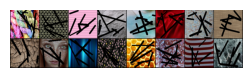

Masking Pattern


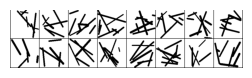

Original Image


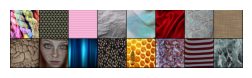

In [69]:
print('Masked Image')
imshow_masked(torchvision.utils.make_grid(X_in))
print('Masking Pattern')
imshow_masked(torchvision.utils.make_grid(X_mask))
print('Original Image')
imshow_masked(torchvision.utils.make_grid(Y_out))

# **Training**

In [27]:
class PartialConv(nn.Module):
    """
    Implements a partial convolution layer, which only considers valid pixels in the convolution operation.
    This is particularly useful for tasks like inpainting where the input image may have missing values.
    """
    def __init__(self, in_filters, out_filters, kernel_size, strides=1, padding=0, dilation=1, groups=1, bias=True):
        super(PartialConv, self).__init__()
        
        # Calculate padding based on the kernel size to ensure the output size is the same as the input size
        padding = (kernel_size[0] // 2, kernel_size[1] // 2)
        self.input_conv = nn.Conv2d(in_filters, out_filters, kernel_size, strides, padding, bias=bias)
        
        # Convolution for mask with weights initialized to 1 and set to not require gradients
        self.mask_conv = nn.Conv2d(in_filters, out_filters, kernel_size, strides, padding, bias=False)
        
        # Constant value for normalizing the mask
        self.window_size = kernel_size[0] * kernel_size[1]
        
        # Initialize mask convolution weights to 1
        nn.init.constant_(self.mask_conv.weight, 1.0)
        
        # Freeze the mask convolution weights
        for param in self.mask_conv.parameters():
            param.requires_grad = False

    def forward(self, input, mask):
        """
        Forward pass of the partial convolution layer.
        
        Parameters:
        - input: The input image.
        - mask: A binary mask indicating which pixels are valid (1) and which are missing (0).
        
        Returns:
        - output: The convolved image, adjusted for valid pixel coverage.
        - output_mask: The updated mask after convolution.
        """
        output = self.input_conv(input * mask)
        
        # Add bias if present, reshaped to match output dimensions
        if self.input_conv.bias is not None:
            output_bias = self.input_conv.bias.view(1, -1, 1, 1).expand_as(output)
        else:
            output_bias = torch.zeros_like(output)

        with torch.no_grad():
            output_mask = self.mask_conv(mask)
            
        # Calculate mask ratio to adjust the convolution output based on the coverage of valid pixels
        mask_ratio = self.window_size / (output_mask + 1e-8)

        output_mask = torch.clamp(output_mask, 0, 1)
  
        mask_ratio = mask_ratio * output_mask
    
        # Adjust output based on valid pixel coverage and add bias
        output = output * mask_ratio
        output = output + output_bias

        return output, output_mask

In [28]:
class EncoderLayer(nn.Module):
    """
    Encoder layer used in the inpainting model, consisting of two partial 
    convolution layers followed by batch normalization and ReLU activation.
    """
    def __init__(self, in_filters, out_filters):
        super(EncoderLayer, self).__init__()
        self.p_conv_1 = PartialConv(in_filters, out_filters, (3, 3), strides=1)
        self.bn_1 = nn.BatchNorm2d(out_filters)
        self.act_1 = nn.ReLU()
        self.p_conv_2 = PartialConv(out_filters, out_filters, (3, 3), strides=2)
        self.bn_2 = nn.BatchNorm2d(out_filters)
        self.act_2 = nn.ReLU()

    def forward(self, inputs, masks):
        """
        Forward pass of the encoder layer, applying two sequential partial convolutions to both inputs and masks.
        
        Parameters:
        - inputs: The input image.
        - masks: The corresponding binary masks.
        
        Returns:
        - A tuple of convolved images and updated masks after each convolution layer.
        """
        conv_out_1, mask_out_1 = self.p_conv_1(inputs, masks)
        conv_out_1 = self.act_1(self.bn_1(conv_out_1))

        conv_out_2, mask_out_2 = self.p_conv_2(conv_out_1, mask_out_1)
        conv_out_2 = self.act_2(self.bn_2(conv_out_2))

        return conv_out_1, mask_out_1, conv_out_2, mask_out_2

In [29]:
class DecoderLayer(nn.Module):
    """
    Decoder layer for the inpainting model, which upsamples the input features 
    and combines them with features from the skip connections, followed 
    by partial convolutions to refine the features for accurate image reconstruction.
    """
    def __init__(self, in_filters_1, in_filters_2):
        super(DecoderLayer, self).__init__()
        
        # Upsample the image and mask to the higher resolution
        self.up_image = nn.Upsample(scale_factor=(2, 2))
        self.up_mask = nn.Upsample(scale_factor=(2, 2))
        
        self.p_conv_1 = PartialConv(in_filters_1 * 2, in_filters_1, (3, 3))
        self.bn_1 = nn.BatchNorm2d(in_filters_1)
        self.act_1 = nn.LeakyReLU(negative_slope=0.2)

        self.p_conv_2 = PartialConv(in_filters_1, in_filters_2, (3, 3))
        self.bn_2 = nn.BatchNorm2d(in_filters_2)
        self.act_2 = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, in_image, in_mask, share_image, share_mask):
        """
        Forward pass of the decoder layer.

        Parameters:
        - in_image: The image features from the previous decoder layer.
        - in_mask: The mask from the previous decoder layer.
        - share_image: The corresponding image features from the encoder layer (skip connection).
        - share_mask: The corresponding mask from the encoder layer (skip connection).

        Returns:
        - A tuple of the convolved images and updated masks after each partial convolution layer.
        """
        up_out = self.up_image(in_image)
        mask_out = self.up_mask(in_mask)
        
        # Concatenate the upsampled features with the features from the skip connection
        concat_image = torch.cat([share_image, up_out], axis=1)
        concat_mask = torch.cat([share_mask, mask_out], axis=1)

        conv_out_1, mask_out_1 = self.p_conv_1(concat_image, concat_mask)
        conv_out_1 = self.act_1(self.bn_1(conv_out_1))
    
        conv_out_2, mask_out_2 = self.p_conv_2(conv_out_1, mask_out_1)
        conv_out_2 = self.act_2(self.bn_2(conv_out_2))

        return conv_out_1, mask_out_1, conv_out_2, mask_out_2

In [30]:
class InpaintingModel(nn.Module):
    def __init__(self, input_dims=(64, 64), num_channels=3):
        super(InpaintingModel, self).__init__()

        self.encoder_1 = EncoderLayer(num_channels, 32)
        self.encoder_2 = EncoderLayer(32, 64)
        self.encoder_3 = EncoderLayer(64, 128)
        self.encoder_4 = EncoderLayer(128, 256)

        self.decoder_1 = DecoderLayer(256, 128)
        self.decoder_2 = DecoderLayer(128, 64)
        self.decoder_3 = DecoderLayer(64, 32)
        self.decoder_4 = DecoderLayer(32, 3)

        self.output_layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True), 

            nn.Conv2d(256, 3, kernel_size=5, padding=2),
            nn.Sigmoid()
        )

    def forward(self, inputs, masks):
        conv_out_1, mask_out_1, conv_out_2, mask_out_2 = self.encoder_1(inputs, masks)
        conv_out_3, mask_out_3, conv_out_4, mask_out_4 = self.encoder_2(conv_out_2, mask_out_2)
        conv_out_5, mask_out_5, conv_out_6, mask_out_6 = self.encoder_3(conv_out_4, mask_out_4)
        conv_out_7, mask_out_7, conv_out_8, mask_out_8 = self.encoder_4(conv_out_6, mask_out_6)

        _, _, _, _ = self.decoder_1(conv_out_8, mask_out_8, conv_out_7, mask_out_7)
        _, _, _, _ = self.decoder_2(conv_out_6, mask_out_6, conv_out_5, mask_out_5)
        _, _, _, _ = self.decoder_3(conv_out_4, mask_out_4, conv_out_3, mask_out_3)
        _, _, conv_out_16, _ = self.decoder_4(conv_out_2, mask_out_2, conv_out_1, mask_out_1)

        outputs = self.output_layer(conv_out_16)
        return outputs

In [31]:
def jaccard_coeff(dataloader):
  for (X_input, X_mask, Y_output) in dataloader:
    X_input, X_mask, Y_output = X_input.to(device), X_mask.to(device), Y_output.to(device)
    outputs = model(X_input, X_mask)
    eps = 1e-15
    outputs = outputs.view(-1)
    Y_output = Y_output.view(-1)
    intersection = (outputs * Y_output).sum()
    union = (outputs.sum() + Y_output.sum()) - intersection
  return (intersection / (union + eps))

In [32]:
from torchvision.models import vgg16
class CombinedLoss(torch.nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.mse_loss = torch.nn.MSELoss()
        self.vgg = vgg16(weights=True).features[:23]  # Using the first few layers of VGG16 for perceptual loss
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, predicted, target):
        # Mean squared error loss
        mse = self.mse_loss(predicted, target)

        # Perceptual loss (VGG feature-based)
        predicted_vgg_features = self.vgg(predicted)
        target_vgg_features = self.vgg(target)
        perceptual_loss = self.mse_loss(predicted_vgg_features, target_vgg_features)

        # Combine losses
        loss = mse + perceptual_loss

        return loss

In [33]:
model = InpaintingModel()
model = model.to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 7303180


In [34]:
loss_fn = CombinedLoss().to(device)
adversarial_loss = nn.BCEWithLogitsLoss()

c:\Users\lenovo\Desktop\burak\ECE176\assignment6\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Initial Memory Allocated: 0.06 Gigabytes
Min loss 2.38759
Epoch: 1, Iteration: 0/118, Loss: 2.38759, IoU: 0.32960
Min loss 2.30651
Min loss 2.15793
Min loss 2.01715
Epoch: 1, Iteration: 10/118, Loss: 2.25198, IoU: 0.35815
Min loss 1.86436
Min loss 1.83722
Min loss 1.73577
Epoch: 1, Iteration: 20/118, Loss: 1.87348, IoU: 0.32443
Min loss 1.71809
Epoch: 1, Iteration: 30/118, Loss: 1.83850, IoU: 0.41866
Min loss 1.64713
Min loss 1.61101
Min loss 1.59929
Min loss 1.59521
Min loss 1.51943
Epoch: 1, Iteration: 40/118, Loss: 1.51943, IoU: 0.47088
Min loss 1.44015
Epoch: 1, Iteration: 50/118, Loss: 1.52551, IoU: 0.43322
Min loss 1.34671
Min loss 1.30797
Epoch: 1, Iteration: 60/118, Loss: 1.56258, IoU: 0.53643
Min loss 1.28795
Min loss 1.26955
Epoch: 1, Iteration: 70/118, Loss: 1.26955, IoU: 0.44998
Epoch: 1, Iteration: 80/118, Loss: 1.30163, IoU: 0.46486
Min loss 1.21832
Min loss 1.19002
Min loss 1.16359
Epoch: 1, Iteration: 90/118, Loss: 1.16359, IoU: 0.47918
Min loss 1.13478
Epoch: 1, Iterat

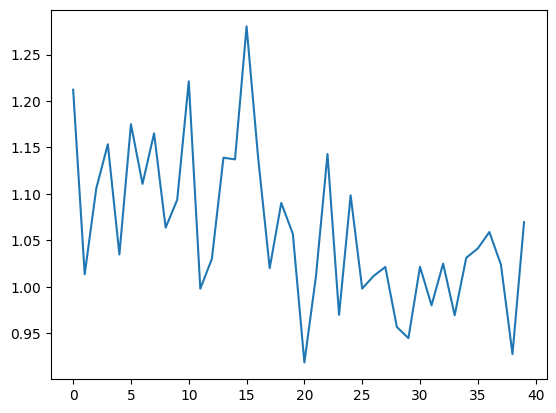

CPU times: total: 9h 10min 50s
Wall time: 1h 57min 37s


In [35]:
%%time
loss_epoch_arr = []
num_epochs = 0
lr = [0.0002, 0.00005]
initial_memory_allocated = torch.cuda.memory_allocated() / (1024 ** 3)
print("Initial Memory Allocated: %0.2f Gigabytes" % initial_memory_allocated)

min_loss = 1000
for learn_rate in lr:
    opt = optim.Adam(model.parameters(), lr=learn_rate)
    max_epochs = 20
    for epoch in range(max_epochs):
        model.train()      
        num_epochs = num_epochs + 1                 
        for i, (X_input, X_mask, Y_output) in enumerate(Trainloader, 0):
            
            # Apply Gaussian noise to X_in
            X_in_noisy = add_gaussian_noise(X_input)
            X_input, X_mask, Y_output = X_in_noisy.to(device), X_mask.to(device), Y_output.to(device)

            opt.zero_grad()

            outputs = model(X_input, X_mask)
            l2_loss = loss_fn(Y_output, outputs)
            adv_loss = adversarial_loss(Y_output, outputs)
            loss = adv_loss + l2_loss
            loss.backward()

            opt.step()

            if min_loss > loss.item():
                min_loss = loss.item()
                best_model = copy.deepcopy(model.state_dict())
                print('Min loss %0.5f' % min_loss)
            
            if i % 10 == 0:
                print('Epoch: %d, Iteration: %d/%d, Loss: %0.5f, IoU: %0.5f' % (num_epochs, i, len(Trainloader), loss.item(), jaccard_coeff(Trainloader)))

            del X_input, X_mask, Y_output
            torch.cuda.empty_cache()
            
        loss_epoch_arr.append(loss.item())    

plt.plot(loss_epoch_arr)
plt.show()

In [36]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [37]:
print(model)

InpaintingModel(
  (encoder_1): EncoderLayer(
    (p_conv_1): PartialConv(
      (input_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (mask_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_1): ReLU()
    (p_conv_2): PartialConv(
      (input_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (mask_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (bn_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_2): ReLU()
  )
  (encoder_2): EncoderLayer(
    (p_conv_1): PartialConv(
      (input_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (mask_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn_1): BatchNorm2d(64, eps=1e-05, moment

In [38]:
torch.save(model.state_dict(), './model_DTD.pt')

In [31]:
model = InpaintingModel()
model = model.to(device)
model.load_state_dict(torch.load('./model_DTD.pt'))
model.eval()

InpaintingModel(
  (encoder_1): EncoderLayer(
    (p_conv_1): PartialConv(
      (input_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (mask_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_1): ReLU()
    (p_conv_2): PartialConv(
      (input_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (mask_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (bn_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_2): ReLU()
  )
  (encoder_2): EncoderLayer(
    (p_conv_1): PartialConv(
      (input_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (mask_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn_1): BatchNorm2d(64, eps=1e-05, moment

# **Results**

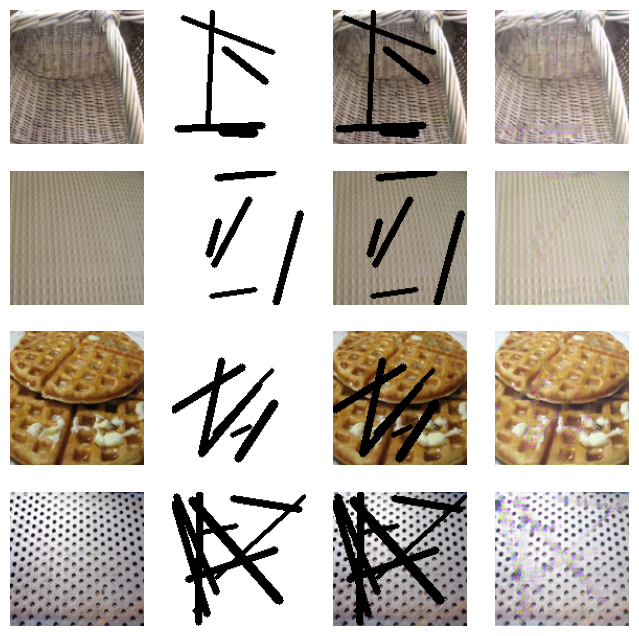

In [39]:
sample_inputs, sample_masks, sample_truths = next(Train_dataiter)
sample_inputs, sample_masks = sample_inputs.cuda(), sample_masks.cuda()

model.eval()
with torch.no_grad():
    sample_preds = model(sample_inputs, sample_masks)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

for i in range(4):
    axs[i][0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
    axs[i][0].axis('off')
    axs[i][1].imshow(np.transpose(sample_masks[i].cpu(), (1, 2, 0)))
    axs[i][1].axis('off')
    axs[i][2].imshow(np.transpose(sample_inputs[i].cpu(),(1, 2, 0)))
    axs[i][2].axis('off')
    axs[i][3].imshow(np.transpose(sample_preds[i].cpu(), (1, 2, 0)))
    axs[i][3].axis('off')
plt.show()

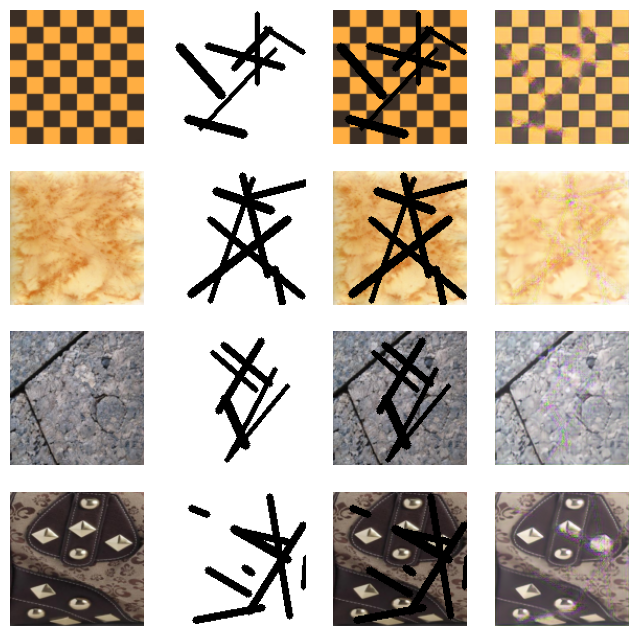

In [76]:
sample_inputs, sample_masks, sample_truths = next(Test_dataiter)
sample_inputs, sample_masks = sample_inputs.cuda(), sample_masks.cuda()

model.eval()
with torch.no_grad():
    sample_preds = model(sample_inputs, sample_masks)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

for i in range(4):
    axs[i][0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
    axs[i][0].axis('off')
    axs[i][1].imshow(np.transpose(sample_masks[i].cpu(), (1, 2, 0)))
    axs[i][1].axis('off')
    axs[i][2].imshow(np.transpose(sample_inputs[i].cpu(),(1, 2, 0)))
    axs[i][2].axis('off')
    axs[i][3].imshow(np.transpose(sample_preds[i].cpu(), (1, 2, 0)))
    axs[i][3].axis('off')
plt.show()

In [34]:
# Call this to download the model weights
"""
model = InpaintingModel()
model = model.to(device)
model.load_state_dict(torch.load('./model.pt'))
model.eval()
"""

"\nmodel = InpaintingModel()\nmodel = model.to(device)\nmodel.load_state_dict(torch.load('./model.pt'))\nmodel.eval()\n"